In [ ]:
!wget https://github.com/aislanacf/Dataset/raw/main/ExerciseDataset.zip
!unzip ExerciseDataset.zip

--2023-06-16 12:45:33--  https://github.com/aislanacf/Dataset/raw/main/ExerciseDataset.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aislanacf/Dataset/main/ExerciseDataset.zip [following]
--2023-06-16 12:45:34--  https://raw.githubusercontent.com/aislanacf/Dataset/main/ExerciseDataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30986909 (30M) [application/zip]
Saving to: ‘ExerciseDataset.zip’

ExerciseDataset.zip 100%[===================>]  29.55M   175MB/s    in 0.2s    

2023-06-16 12:45:34 (175 MB/s) - ‘ExerciseDataset.zip’ saved [30986909/30986909]

Archive:  ExerciseDataset.zi

In [ ]:
from google.colab import drive
# mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# adjust the path to the location where the models will be written / read
root_path = '/content/drive/My Drive/Colab Notebooks/'

#dataset_path = "/content/drive/My Drive/Dataset/"

dataset_path = "/content/ExerciseDataset/"

Mounted at /content/drive


In [ ]:
import os
# Creating folder name list for training
train_folders = sorted([entry for entry in os.listdir(dataset_path)
                            if os.path.isdir(os.path.join(dataset_path,
                                                          entry))])

# As the set of images is small, tiles 2, 4 and 6 folders will be used to evaluate the models.
evaluate_folders = []
evaluate_folders.append(train_folders.pop(1))
#train_folders.remove(".ipynb_checkpoints")
#train_folders.remove("Tile8")
#train_folders.remove("Tile7")
print(train_folders)
print(evaluate_folders)

['Tile1', 'Tile3', 'Tile4', 'Tile5', 'Tile6', 'Tile7', 'Tile8']
['Tile2']


In [ ]:
import cv2
# Function to read images
def loadImages(datasetPath, folders, normalize=False):
    images = []
    masks = []

    for folder in folders:
        path = os.path.join(datasetPath,folder)

        for entry in sorted(os.listdir(os.path.join(path,'images'))):
            filename = entry[0:-4]

            # OpenCV returns channels in BGR order. Convert to RGB. Only, in this dataset images are organized as BGR
            #img = cv2.cvtColor(cv2.imread(os.path.join(path,'images', filename + '.jpg')), cv2.COLOR_BGR2RGB)
            img = cv2.imread(os.path.join(path,'images', filename + '.jpg'))
            mask = cv2.cvtColor(cv2.imread(os.path.join(path,'masks', filename + '.png')), cv2.COLOR_BGR2GRAY)

            if img is not None and mask is not None:
                if normalize:
                    img = img / 255.

                images.append(img)
                masks.append(mask)

    return images, masks

   # Loading all existing images in Dataset (training) Folders

all_images, all_masks = loadImages(dataset_path, train_folders, True)

print( "Number of images (X): %d " % ( len(all_images) ) )
print( "Number of masks/references (Y): %d " % ( len(all_masks) ) )

Number of images (X): 63 
Number of masks/references (Y): 63 


In [ ]:
import numpy as np
def extract_patches(image, reference, patch_size, stride):
    #print(image.shape)

    patch_img = []
    patch_ref = []

    h = image.shape[0] // stride
    w = image.shape[1] // stride

    for m in range(0, h):
        for n in range(0, w):
        #print('M %d, N %d, start %d finish %d , start %d finish %d' % (m, n, m*stride , m*stride+patch_size, n*stride, n*stride+patch_size) )
            if ( (m*stride+patch_size <= image.shape[0]) and (n*stride+patch_size <= image.shape[1]) ): # only if it fits inside the image
                patch_img.append( image[m*stride:m*stride+patch_size,n*stride:n*stride+patch_size,:] )
                patch_ref.append( reference[m*stride:m*stride+patch_size,n*stride:n*stride+patch_size] )

    return patch_img, patch_ref

def extract_patches_from_list(images, references, patch_size, stride):
    patch_img = []
    patch_ref = []

    for i in range(0, len(images)):
        xTemp, yTemp = extract_patches(images[i], references[i], patch_size, stride)

        patch_img += xTemp
        patch_ref += yTemp

    return np.array(patch_img), np.array(patch_ref)

patch_size = 256
stride = patch_size - (patch_size // 8)
#channels = 3
#input_shape = (patch_size, patch_size, channels)
x_patches, y_patches = extract_patches_from_list( all_images, all_masks,
                                                     patch_size, stride)

print( "Total patches: %d of shapes %s " % ( x_patches.shape[0],
                                                x_patches.shape[1:] ) )
number_of_classes = 6
classes = { "length": number_of_classes,
            "annotations": [
                { "id": 1, "name": "Land (unpaved area)", "gray": 92, "rgb": (132, 41, 246), "rgb_new": (155, 155, 155), "hex": "8429F6" },
                { "id": 2, "name": "Road", "gray": 172, "rgb": (110, 193, 228), "rgb_new": (245, 175, 13), "hex": "6EC1E4" },
                { "id": 3, "name": "Vegetation", "gray": 212, "rgb": (254, 221, 58), "rgb_new": (126, 228, 82), "hex": "FEDD3A" },
                { "id": 4, "name": "Water", "gray": 171, "rgb": (226, 169, 41), "rgb_new": (81, 126, 231), "hex": "E2A929" },
                { "id": 5, "name": "Building", "gray": 45, "rgb": (60, 16, 152), "rgb_new": (232, 9, 247), "hex": "3C1098" },
                { "id": 0, "name": "Unlabeled", "gray": 155, "rgb": (155, 155, 155), "rgb_new": (0, 0, 0), "hex": "9B9B9B" }
           ]}

Total patches: 1476 of shapes (256, 256, 3) 


In [ ]:
tmp = np.zeros((y_patches.shape[0],) + (256,256), dtype="uint8")

for annotation in classes['annotations']:
    tmp = tmp + ( ( y_patches == annotation['gray'] ) * annotation['id'] )

y_patches = tmp
tmp = []

#print(y_patches.shape)

In [ ]:
print(y_patches.shape)
y_patches = np.expand_dims(y_patches, 3)
print(y_patches.shape)

(1476, 256, 256)
(1476, 256, 256, 1)


In [ ]:
from sklearn.model_selection import train_test_split
valid_percent = 0.25

(x_train, x_valid, y_train, y_valid) = train_test_split(x_patches, y_patches,
                                  test_size=valid_percent, random_state=1)

print( "Number of patches/samples in the training set: %d " % (len(x_train)))
print( "Number of patches/samples in the validation set: %d " % (len(x_valid)))
#print(x_train.shape)
#print(y_train.shape)
#print(x_valid.shape)
#print(y_valid.shape)

Number of patches/samples in the training set: 1107 
Number of patches/samples in the validation set: 369 


In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.layers import Conv2DTranspose, concatenate
def unet_v3(input_shape, n_classes):
    s = inputs = Input(shape=(256,patch_size,channels))
# begin with contraction part
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(s)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
               padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c2)

    c4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p1)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c4)
    p2 = MaxPooling2D((2, 2))(c5)

    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p2)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c7)
    p3 = MaxPooling2D((2, 2))(c8)

    c10 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p3)
    c11 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c10)

    u12 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c11)
    u12 = concatenate([u12, c7])
    c12 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                 padding='same')(u12)
    c13 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal',
                 padding='same')(c12)

    u14 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c13)
    u14 = concatenate([u14, c4], axis=3)
    c14 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u14)

    c15 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(c14)

    u16 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c15)
    u16 = concatenate([u16, c2], axis=3)
    c16 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u16)
    c17 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                 padding='same')(c16)


    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c17)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


def unet_v2(input_shape, n_classes):
    s = inputs = Input(shape=(256,patch_size,channels))
    # begin with contraction part
    c1 = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(s)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p3)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(p4)

    u6 = Conv2DTranspose(filters = 128, kernel_size = (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u6)

    u7 = Conv2DTranspose(filters = 64, kernel_size = (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u7)

    u8 = Conv2DTranspose(filters = 32, kernel_size = (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u8)

    u9 = Conv2DTranspose(filters = 16, kernel_size = (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(filters = 16, kernel_size =(3, 3), activation='relu', kernel_initializer='he_normal',
                padding='same')(u9)

    # define output layer
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[s], outputs=[outputs])

    return model

def unet(input_shape, n_classes):
    patch_size = 256
    channels = 3
    stride = patch_size - (patch_size // 8)
    inputs = Input(shape=(256,patch_size,channels))

    conv_1 = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')\
                    (inputs)

    conv_2 = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')\
                    (conv_1)
    pool_1 = MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid')\
                    (conv_2)
    conv_3 = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')\
                    (pool_1)
    conv_4 = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')\
                    (conv_3)
    pool_2 = MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid')\
                    (conv_4)
    conv_5 = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu')\
                    (pool_2)
    conv_6 = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu')\
                    (conv_5)
    pool_3 = MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid')\
                    (conv_6)
    conv_7 = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu')\
                    (pool_3)
    conv_8 = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu')\
                    (conv_7)

    up_conv_9 = UpSampling2D(size=(2, 2))(conv_8)
    up_conv_10 = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu')\
                    (up_conv_9)
    up_conv_11 = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu')\
                    (up_conv_10)
    up_conv_12 = UpSampling2D(size=(2, 2))(up_conv_11)
    up_conv_13 = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')\
                    (up_conv_12)

    up_conv_14 = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')\
                    (up_conv_13)
    up_conv_15 = UpSampling2D(size=(2, 2))(up_conv_14)
    up_conv_16 = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')\
                    (up_conv_15)

    up_conv_17 = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')\
                    (up_conv_16)
    out = Conv2D(n_classes, kernel_size  = (3,3),  padding='same',
                 activation = 'softmax', )(up_conv_17)

    model = Model(inputs=inputs, outputs=out, name='U-Net')

    return model


patch_size = 256
stride = patch_size - (patch_size // 8)
channels = 3
input_shape = (patch_size, patch_size, channels)
model = unet_v3(input_shape, number_of_classes)
print(model.summary())



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_8 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d_7[0][0]']               
                                )                                                             

In [ ]:
all_images = 0
all_masks = 0
x_patches = 0
y_patches = 0

In [ ]:
#from tensorflow.python.keras.optimizers import Adam
from keras.optimizers import Adam
#batch_size = 64
#epochs = 50

# Fixed class weights
weights = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

# Early Stop parameters
early_stopping_epochs = 20
early_stopping_delta = 0.0001 # delta improvement equivalent to 0.0001%

# Data augmentation parameters
data_augmentation = False
number_samples_for_generator = 4

# Optimizer
adam = Adam(learning_rate = 0.0005, beta_1=0.9)

# Compile the model
model.compile(loss = "sparse_categorical_crossentropy", optimizer=adam , metrics=['accuracy'], loss_weights=weights)

filename = 'modelo_unet'

In [ ]:
from keras import callbacks
es = callbacks.EarlyStopping(monitor="val_loss",
                              mode="min", patience=5,
                              restore_best_weights=True)

history = model.fit(x_train, y_train, validation_data=(x_valid,y_valid), epochs=2, batch_size=32,
                        verbose=1, callbacks=[es])

print(history.history['accuracy'])


Epoch 1/2
35/35 [==============================] - 2789s 80s/step - loss: 0.5776 - accuracy: 0.5615 - val_loss: 0.5024 - val_accuracy: 0.5870
Epoch 2/2
35/35 [==============================] - 2747s 79s/step - loss: 0.4530 - accuracy: 0.6636 - val_loss: 0.4218 - val_accuracy: 0.7029
[0.5614864230155945, 0.6635746955871582]


In [ ]:
import matplotlib.pyplot as plt
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
def show_graph_loss_accuracy(history,accuracy_position):
    plt.rcParams['axes.facecolor']='white'
    plt.figure(num=1, figsize=(14,6))

    config = [ { 'title': 'model accuracy', 'ylabel': 'accuracy', 'legend_position': 'upper left', 'index_position': accuracy_position },
               { 'title': 'model loss', 'ylabel': 'loss', 'legend_position': 'upper right', 'index_position': 0 } ]

    for i in range(len(config)):

        plot_number = 120 + (i+1)
        plt.subplot(plot_number)
        #plt.plot(history[0,:,0,config[i]['index_position']])
        plt.plot(history.history[config[i],['index_position']])
        plt.plot(history[1,:,0,config[i]['index_position']])
        plt.title(config[i]['title'])
        plt.ylabel(config[i]['ylabel'])
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc=config[i]['legend_position'])
        plt.tight_layout()

    plt.show()

In [ ]:
model.save(root_path+filename+'.h5')

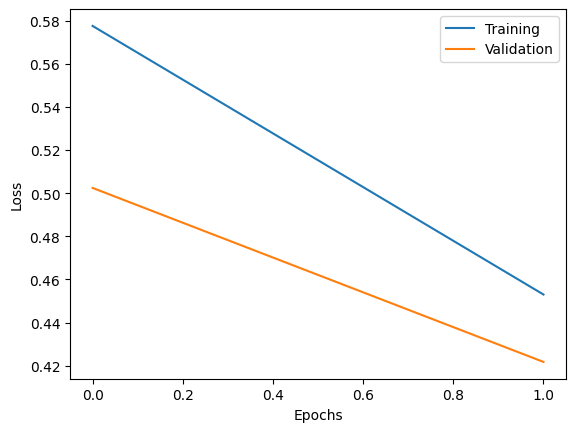

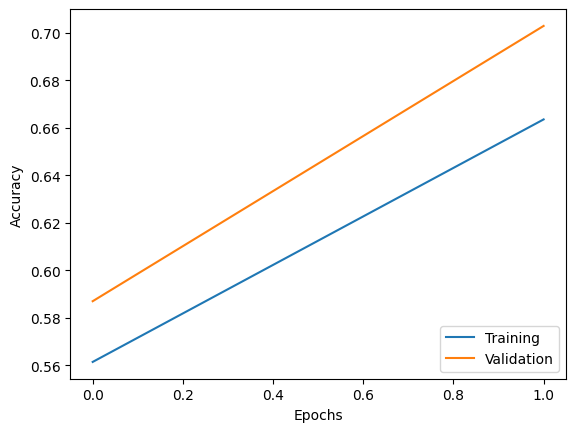

In [ ]:
plot_history(history)
#print(history.history.keys())


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
# Function to evaluate the model
def Test(model, patch_test):
    result = model.predict(patch_test)
    predicted_class = np.argmax(result, axis=-1)
    return predicted_class

# Function to compute accuracy metrics
def compute_metrics(true_labels, predicted_labels):
    accuracy = 100*accuracy_score(true_labels, predicted_labels)
    f1score = 100*f1_score(true_labels, predicted_labels, average=None)
    recall = 100*recall_score(true_labels, predicted_labels, average=None)
    precision = 100*precision_score(true_labels, predicted_labels, average=None)
    return accuracy, f1score, recall, precision

In [ ]:
# Load the best model (file type .h5)
from keras.models import  load_model
filename = 'modelo_unet'
model = load_model(root_path + filename + '.h5', compile=False)

In [ ]:
# Test the model using some of the training data
# Function to evaluate the model
def Test(model, patch_test):
    result = model.predict(patch_test)
    predicted_class = np.argmax(result, axis=-1)
    return predicted_class

pred_train = Test(model, x_train[0:40])

2/2 [==============================] - 25s 5s/step


In [ ]:
import glob
import cv2
def Rotation(image):

    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2),45,.5)
    rotated_image = cv2.warpAffine(image, rotation_matrix,(width, height))
    return rotated_image

def Flipping(image):
    flip = cv2.flip(image, 3)
    return flip

def Sharpening(image):
    sharpening = np.array([[-1, -1, -1],
                             [-1,10,-1],
                             [-1, -1, -1]],  np.uint8)
    sharpened = cv2.filter2D(image,-1, sharpening)
    return sharpened

def rotate_im(image, angle):
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    imageR = cv2.warpAffine(image, M, (nW, nH))

    #imageOut = cv2.resize(imageR, (w,h))

    return imageR


Plotting images...


(-0.5, 255.5, 255.5, -0.5)

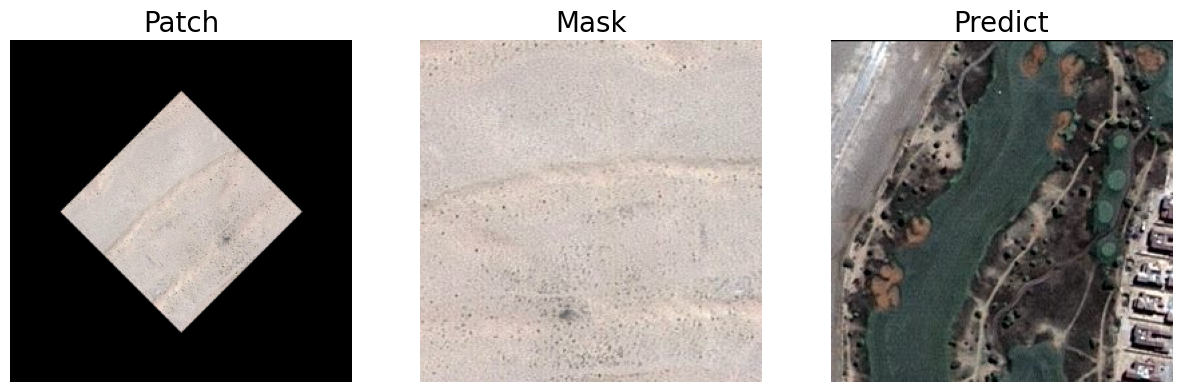

In [ ]:
import matplotlib.pyplot as plt
def labelVisualize(class_dict,field,img):

    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))  # shape = 256,256,3

    for annotation in class_dict['annotations']:
        img_out[ img == annotation[field] ] = annotation['rgb_new']

    return img_out / 255
#index = 7

print('\nPlotting images...')
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 15))
ax1.imshow(Rotation(x_train[7]))
ax1.set_title('Patch', fontsize=20)
ax1.axis('off')

ax2.imshow( Flipping( x_train[7] ) )
ax2.set_title('Mask', fontsize=20)
ax2.axis('off')

ax3.imshow( rotate_im( x_train[10], 90 ) )
ax3.set_title('Predict', fontsize=20)
ax3.axis('off')

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
# Function to compute accuracy metrics
def compute_metrics(true_labels, predicted_labels):
    accuracy = 100*accuracy_score(true_labels, predicted_labels)
    f1score = 100*f1_score(true_labels, predicted_labels, average=None)
    recall = 100*recall_score(true_labels, predicted_labels, average=None)
    precision = 100*precision_score(true_labels, predicted_labels, average=None)
    return accuracy, f1score, recall, precision

# Turn labels into unidimensional vectors for accuracy assessment
true_labels = np.reshape(y_train[0:40], (y_train[0:40].shape[0]* y_train[0:40].shape[1]*y_train[0:40].shape[2]))
predicted_labels = np.reshape(pred_train, (pred_train.shape[0]* pred_train.shape[1]*pred_train.shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[      0   30110       4     935     267    8379]
 [      0 1411723      15   31050   15202  121546]
 [      0  154549      43   23729    3830   91585]
 [      0   13874      16   61933  107018   59164]
 [      0    9734      19   10280  155817    7484]
 [      0   29275       0   23714    3105  247040]]

Metrics
Accuracy:  71.58493041992188
F1score:  [0.00000000e+00 8.74456493e+01 3.14060029e-02 3.14663429e+01
 6.65070331e+01 5.89360778e+01]
Recall:  [0.00000000e+00 8.93758040e+01 1.57085659e-02 2.55916200e+01
 8.49907819e+01 8.14953123e+01]
Precision:  [ 0.         85.59709931 44.32989691 40.84185675 54.62682172 46.15861793]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Load the best model (file type .h5)
filename = 'modelo_unet'
model = load_model(root_path + filename + '.h5', compile=False)

In [ ]:
# Loading all existing images in Test Folders
all_images, all_masks = loadImages(dataset_path, evaluate_folders, True)

# Extract test patches
x_test, y_test = extract_patches_from_list( all_images, all_masks, patch_size, stride)

tmp = np.zeros((y_test.shape[0],) + (256,256), dtype="uint8")
for annotation in classes['annotations']:
    tmp = tmp + ( ( y_test == annotation['gray'] ) * annotation['id'] )
y_test = tmp

tmp = []
all_images = []
all_masks = []

print( "Total of test patches/samples: %d of shape %s " % ( x_test.shape[0], y_test.shape[1:] ) )

Total of test patches/samples: 36 of shape (256, 256) 


In [ ]:
# Test the model
pred_test_unet = Test(model, x_test)
print(pred_test_unet.shape)

2/2 [==============================] - 22s 3s/step
(36, 256, 256)


In [ ]:
true_labels = np.reshape(y_test, (y_test.shape[0]* y_test.shape[1]*y_test.shape[2]))
predicted_labels = np.reshape(pred_test_unet, (pred_test_unet.shape[0]* pred_test_unet.shape[1]*pred_test_unet.shape[2]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion  matrix')
print('=================')
print(cm)

# Metrics
metrics = compute_metrics(true_labels, predicted_labels)
print('\nMetrics')
print('=======')
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix
[[      0   17082       0    6839     879   18240]
 [      0 1038769      11   75485   10423  319346]
 [      0   69564      30   73605    2474  165115]
 [      0   18318       2   29410   53962   23777]
 [      0       1       0     474  154715      50]
 [      0  101873       1   10825    2704  165322]]

Metrics
Accuracy:  58.84153578016493
F1score:  [0.00000000e+00 7.72422044e+01 1.93030319e-02 1.82610126e+01
 8.13439643e+01 3.39967612e+01]
Recall:  [0.00000000e+00 7.19352176e+01 9.65288235e-03 2.34400529e+01
 9.96618140e+01 5.88910856e+01]
Precision:  [ 0.         83.39460199 68.18181818 14.95641738 68.71427493 23.89564212]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
